In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import numpy as np
from jax import grad, vmap
import jax
import jax.random as jrandom
import matplotlib.pyplot as plt
from models import *
from advi import *
import pymc
from pymc import HalfCauchy, Model, Normal, sample, Gamma


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def get_samples_pymc(X_data,y, gamma_prior=1):
    with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
        # Define priors
        X_data_pm = pymc.MutableData("xdata",np.array(X_data).T)
        y_pm = pymc.MutableData("ydata",y)

        sigma = Gamma("sigma", alpha=gamma_prior,beta=gamma_prior)
        slope = Normal("slope", 0, sigma=1, shape=d)
        # Define likelihood
        likelihood = Normal("y", mu=slope@X_data_pm, sigma=sigma, observed=y_pm)

        # Inference!
        # draw 3000 posterior samples using NUTS sampling
        idata = sample(3000, tune=1000)
        samples =  np.array(idata.posterior['slope'])
        samples = np.vstack(samples)
        mean = np.mean(samples, axis=0)
        variance = np.var(samples, axis=0)
        return mean, variance
    
def get_val_advi(X_data,y, gamma_prior=1, random_state=2):
    linear_model = LinearModel(X_data, y, gamma_prior, gamma_prior)
    linear_advi = mean_field_advi(linear_model)
    loss_adaptive = linear_advi.run_advi(
        jrandom.key(random_state), 10, 10001, 1e-3, print_every=2000, adaptive=True, alpha=0.5, rmsprop=True
    )
    return linear_advi.params["mu"], linear_advi.params["sigma"], linear_advi

In [4]:
N = 100
d = 30
key = jrandom.key(42)
k1, k2, k3 = jrandom.split(key, 3)
X_data = jrandom.normal(k1, shape=(N, d))
w_star = jrandom.normal(k2, shape=(d,)) * 2
y = X_data @ w_star
linear_model = LinearModel(X_data, y, 1, 1)
linear_advi = mean_field_advi(linear_model)
key = jrandom.key(52)
X_data_np = np.array(X_data)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [12]:
mean, variance = get_samples_pymc(X_data, y)
mean_advi, variance_advi, advi = get_val_advi(X_data, y)
samples_advi = advi.sample_advi(jrandom.key(2),num=12_000)[:-1].T
mean_advi = jnp.mean(samples_advi, axis=0)
variance_advi = jnp.var(samples_advi, axis=0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope]
/home/hegz/anaconda3/envs/311/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/hegz/anaconda3/envs/311/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.


-38095.04
-381.16327
-304.04343
-245.00426
-236.46585
-236.73222


In [18]:
variance_advi.shape

(30,)

In [13]:
minm = min([np.min(variance), np.min(variance_advi**2)])
maxm = max([np.max(variance), np.max(variance_advi**2)])

In [22]:
plt.rcParams.update({'figure.autolayout': True})

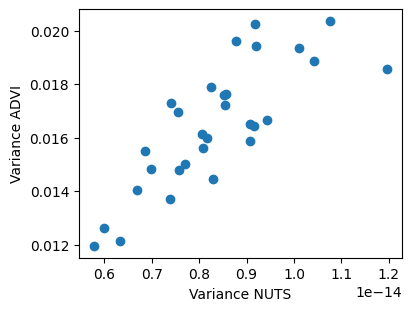

In [32]:
plt.figure(figsize=(4, 3), constrained_layout=True)#,w_pad=0, h_pad=0 )

# plt.rcParams['savefig.facecolor'] = "0.8"

# plt.set_constrained_layout_pads(w_pad=0, h_pad=0)
plt.scatter(variance,variance_advi)
plt.xlabel("Variance NUTS")
plt.ylabel("Variance ADVI")
plt.savefig("regression_var.pdf")
# plt.tight_layout()
# plt.plot(np.linspace(minm, maxm, 100),np.linspace(minm, maxm, 100))
plt.show()

<Figure size 400x300 with 0 Axes>

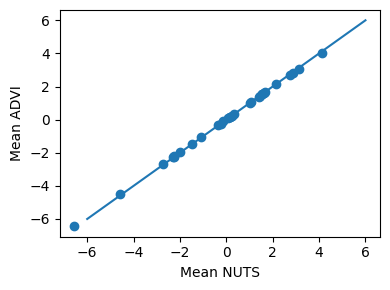

In [31]:
plt.figure(figsize=(4, 3), constrained_layout=True)#,w_pad=0, h_pad=0 )

plt.figure(figsize=(4, 3))
plt.scatter(mean, mean_advi
            )
plt.xlabel("Mean NUTS")
plt.ylabel("Mean ADVI")
plt.plot(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
# plt.tight_layout()

plt.savefig("regression_mean.pdf")

plt.show()

In [ ]:
N = 100
d = 30
key = jrandom.key(42)
k1, k2, k3 = jrandom.split(key, 3)
X_data = jrandom.normal(k1, shape=(N, d))
w_star = jrandom.normal(k2, shape=(d,)) * 2
y = X_data @ w_star
linear_model = LinearModel(X_data, y, 1, 1)
linear_advi = mean_field_advi(linear_model)
key = jrandom.key(52)
linear_advi = mean_field_advi(linear_model)
loss_1_adaptive = linear_advi.run_advi(
    key, 1, 1001, 1e-3, print_every=500, adaptive=True, alpha=0.5
)

In [ ]:

linear_advi = mean_field_advi(linear_model)

loss_1_fixed = linear_advi.run_advi(
    key, 1, 1001, 1e-4, print_every=500, adaptive=False, alpha=0.5
)

linear_advi = mean_field_advi(linear_model)

loss_10_adaptive = linear_advi.run_advi(
    key, 10, 1001, 1e-3, print_every=500, adaptive=True, alpha=0.5
)
linear_advi = mean_field_advi(linear_model)

loss_10_fixed = linear_advi.run_advi(
    key, 10, 1001, 1e-4, print_every=500, adaptive=False, alpha=0.5
)